## ddpm的总结

### 模型的解析

In [ ]:
class Swish(nn.Module):  # 定义一个名为Swish的类，继承自nn.Module，用于实现Swish激活函数
    def forward(self, x):  # 定义前向传播函数，接受输入x
        return x * torch.sigmoid(x)  # 返回输入x与其sigmoid函数值的乘积，即Swish激活函数的计算公式

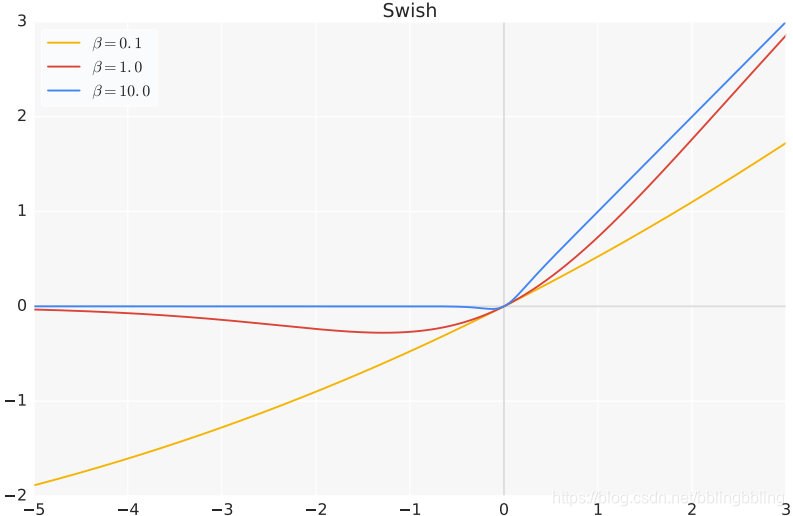

时间步长编码

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        # 确保d_model是偶数
        assert d_model % 2 == 0
        super().__init__()
        # 创建一个从0到d_model-1，步长为2的序列，用于计算位置编码
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        # 计算e的负指数，用于缩放
        emb = torch.exp(-emb)
        # 创建一个从0到T-1的序列，表示时间步
        pos = torch.arange(T).float()
        # 计算位置编码
        emb = pos[:, None] * emb[None, :]
        # 确保emb的形状为[T, d_model // 2]
        assert list(emb.shape) == [T, d_model // 2]
        # 使用正弦和余弦函数生成位置编码
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        # 确保emb的形状为[T, d_model // 2, 2]
        assert list(emb.shape) == [T, d_model // 2, 2]
        # 将emb的形状调整为[T, d_model]
        emb = emb.view(T, d_model)

        # 定义时间嵌入的网络结构
        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),  # 使用预训练的位置编码
            nn.Linear(d_model, dim),  # 线性变换
            Swish(),  # 激活函数
            nn.Linear(dim, dim),  # 再次线性变换
        )
        self.initialize()  # 初始化网络参数

    def initialize(self):
        # 遍历所有子模块，初始化线性层的权重和偏置
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)  # 使用Xavier均匀分布初始化权重
                init.zeros_(module.bias)  # 将偏置初始化为0

    def forward(self, t):
        # 前向传播，获取时间嵌入
        emb = self.timembedding(t)
        return emb

下采样和上采样

In [ ]:
class DownSample(nn.Module):
    # 定义一个下采样类，继承自nn.Module
    def __init__(self, in_ch):
        # 构造函数，初始化下采样层
        super().__init__()
        # 调用父类的构造函数
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        # 定义一个二维卷积层，输入通道数和输出通道数均为in_ch，卷积核大小为3x3，步长为2，填充为1
        self.initialize()

        # 调用初始化函数
    def initialize(self):
        # 初始化函数，用于初始化卷积层的权重和偏置
        init.xavier_uniform_(self.main.weight)
        # 使用Xavier均匀分布初始化卷积层的权重
        init.zeros_(self.main.bias)

        # 将卷积层的偏置初始化为0
    def forward(self, x, temb):
        # 前向传播函数，输入为x和temb
        x = self.main(x)
        # 对输入x进行卷积操作
        return x


class UpSample(nn.Module):
    # 定义一个上采样类，继承自nn.Module
    def __init__(self, in_ch):

        # 构造函数，初始化上采样层
        super().__init__()  # 调用父类的构造函数
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)

        # 定义一个二维卷积层，输入通道数和输出通道数均为in_ch，卷积核大小为3x3，步长为1，填充为1
        self.initialize()  # 调用初始化函数

    def initialize(self):
        # 初始化函数，用于初始化卷积层的权重和偏置
        init.xavier_uniform_(self.main.weight)
        # 使用Xavier均匀分布初始化卷积层的权重
        init.zeros_(self.main.bias)

        # 将卷积层的偏置初始化为0
    def forward(self, x, temb):
        # 前向传播函数，输入为x和temb（虽然temb在当前代码中未使用）
        _, _, H, W = x.shape
        # 获取输入张量x的形状，_表示忽略的维度，H和W分别表示高度和宽度
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        # 使用最近邻插值法将输入张量x的尺寸放大两倍
        x = self.main(x)
        # 将上采样后的张量通过卷积层进行处理
        return x


注意力模块（然而我在训练没用这个，没那么多时间）

In [ ]:
class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        # 初始化父类
        super().__init__()
        # 创建GroupNorm层，用于规范化输入特征
        self.group_norm = nn.GroupNorm(32, in_ch)
        # 创建卷积层，用于生成查询矩阵Q
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        # 创建卷积层，用于生成键矩阵K
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        # 创建卷积层，用于生成值矩阵V
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        # 创建卷积层，用于生成最终的输出
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        # 初始化权重
        self.initialize()

    def initialize(self):
        # 对卷积层权重进行Xavier均匀初始化，偏置初始化为0
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        # 对最后一个卷积层的权重进行Xavier均匀初始化，但增益设置为1e-5
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        # 获取输入的形状
        B, C, H, W = x.shape
        # 对输入进行GroupNorm规范化
        h = self.group_norm(x)
        # 生成查询矩阵Q
        q = self.proj_q(h)
        # 生成键矩阵K
        k = self.proj_k(h)
        # 生成值矩阵V
        v = self.proj_v(h)

        # 将Q的维度从[B, C, H, W]转换为[B, H*W, C]
        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        # 将K的维度从[B, C, H, W]转换为[B, C, H*W]
        k = k.view(B, C, H * W)
        # 计算注意力权重，并进行缩放
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        # 确保权重矩阵的形状为[B, H*W, H*W]
        assert list(w.shape) == [B, H * W, H * W]
        # 对权重矩阵进行softmax归一化
        w = F.softmax(w, dim=-1)

        # 将V的维度从[B, C, H, W]转换为[B, H*W, C]
        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        # 计算加权和
        h = torch.bmm(w, v)
        # 确保加权和的形状为[B, H*W, C]
        assert list(h.shape) == [B, H * W, C]
        # 将加权和的维度从[B, H*W, C]转换回[B, C, H, W]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        # 通过卷积层生成最终输出
        h = self.proj(h)

        # 返回输入和输出的加权和，实现残差连接
        return x + h

残差连接块

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        # 初始化父类
        super().__init__()
        # 第一个块：包含GroupNorm、Swish激活函数和卷积层
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),  # 对输入通道进行归一化
            Swish(),  # Swish激活函数
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),  # 3x3卷积层
        )
        # 时间嵌入投影：包含Swish激活函数和线性层
        self.temb_proj = nn.Sequential(
            Swish(),  # Swish激活函数
            nn.Linear(tdim, out_ch),  # 线性层，将时间嵌入维度映射到输出通道数
        )
        # 第二个块：包含GroupNorm、Swish激活函数、Dropout和卷积层
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),  # 对输出通道进行归一化
            Swish(),  # Swish激活函数
            nn.Dropout(dropout),  # Dropout层
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),  # 3x3卷积层
        )
        # 如果输入通道数和输出通道数不同，则使用1x1卷积层进行维度变换
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()  # 如果相同，则直接传递
        # 如果需要注意力机制，则使用AttnBlock，否则使用Identity
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        # 初始化权重
        self.initialize()


    def initialize(self):
        # 遍历所有模块，对卷积层和线性层进行权重初始化
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)  # 使用Xavier均匀分布初始化权重
                init.zeros_(module.bias)  # 偏置初始化为0
        # 对第二个块的最后一个卷积层进行特殊初始化
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        # 第一个块处理输入
        h = self.block1(x)
        # 将时间嵌入投影加到特征图上
        h += self.temb_proj(temb)[:, :, None, None]
        # 第二个块处理特征图
        h = self.block2(h)

        # 残差连接：将输入直接加到输出上
        h = h + self.shortcut(x)
        # 应用注意力机制
        h = self.attn(h)
        return h

一整个unet模块

In [ ]:
class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

### difusion

In [ ]:
def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    # 获取t所在的设备（CPU或GPU）
    device = t.device
    # 使用torch.gather函数从v中按照t指定的索引提取元素
    # v: 输入的张量，t: 指定的索引，dim=0表示沿着第0维进行索引
    # .float()将提取出的元素转换为浮点数
    # .to(device)将结果移动到与t相同的设备上
    out = torch.gather(v, index=t, dim=0).float().to(device)
    # 将提取出的结果重新形状为[t.shape[0]] + [1] * (len(x_shape) - 1)
    # t.shape[0]表示batch_size，[1] * (len(x_shape) - 1)表示在除了batch_size之外的维度上添加1
    # 这样做的目的是为了方便后续的广播操作
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))

In [ ]:
class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        # 初始化模型
        self.model = model
        # 设置扩散步数
        self.T = T

        # 注册缓冲区，存储从beta_1到beta_T的线性空间，用于扩散过程
        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        # 计算alphas，即1减去betas
        alphas = 1. - self.betas
        # 计算alphas的累积乘积，用于后续计算
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def forward(self, x_0):
        """
        Algorithm 1.
        """
        # 生成一个随机的时间步t，范围在0到self.T之间，大小与x_0的第一个维度相同，设备与x_0相同
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        # 生成与x_0形状相同的正态分布噪声
        noise = torch.randn_like(x_0)
        # 计算在时间步t的噪声数据x_t
        # 使用extract函数从self.sqrt_alphas_bar中提取对应时间步t的值，并与x_0相乘
        # 使用extract函数从self.sqrt_one_minus_alphas_bar中提取对应时间步t的值，并与噪声相乘
        # 将上述两个结果相加得到x_t
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)
        # 计算模型预测的噪声与真实噪声之间的均方误差损失
        # self.model(x_t, t)表示模型在时间步t对x_t的预测
        # noise表示真实的噪声
        # reduction='none'表示不进行任何形式的损失聚合，返回每个样本的损失
        loss = F.mse_loss(self.model(x_t, t), noise, reduction='none')
        # 返回计算得到的损失
        return loss

In [ ]:
class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        # 初始化模型、时间步数T
        self.model = model
        self.T = T

        # 注册缓冲区，存储从beta_1到beta_T的线性空间
        self.register_buffer('betas', torch.linspace(beta_1, beta_T, T).double())
        # 计算alphas，即1减去betas
        alphas = 1. - self.betas
        # 计算累积乘积alphas_bar
        alphas_bar = torch.cumprod(alphas, dim=0)
        # 计算前一个时间步的alphas_bar
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        coeff1 = torch.sqrt(1. / alphas)
        coeff2 = coeff1 * (1. - alphas) / torch.sqrt(1. - alphas_bar)
        # 计算系数coeff1和coeff2
        self.register_buffer('coeff1', coeff1)
        self.register_buffer('coeff2', coeff2)

        # 计算后验方差
        self.register_buffer('posterior_var', self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))

    def predict_xt_prev_mean_from_eps(self, x_t, t, eps):
        # 确保x_t和eps的形状相同
        assert x_t.shape == eps.shape
        # 根据公式计算x_{t-1}的均值
        return (
            extract(self.coeff1, t, x_t.shape) * x_t -
            extract(self.coeff2, t, x_t.shape) * eps
        )

    def p_mean_variance(self, x_t, t):
        # below: only log_variance is used in the KL computations
        var = torch.cat([self.posterior_var[1:2], self.betas[1:]])
        var = extract(var, t, x_t.shape)
        
        print("NaN in x_t:", torch.isnan(x_t).sum().item())

        eps = self.model(x_t, t)
        xt_prev_mean = self.predict_xt_prev_mean_from_eps(x_t, t, eps=eps)

        return xt_prev_mean, var

    def forward(self, x_T):
        """
        Algorithm 2.
        """
        # 初始化x_t为输入的x_T
        x_t = x_T
        # 从最后一个时间步开始，倒序遍历到第一个时间步
        for time_step in reversed(range(self.T)):
            # 打印当前时间步
            print(time_step)
            # 创建一个与x_T形状相同的张量，所有元素初始化为当前时间步的值
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            # 计算当前时间步的均值和方差
            mean, var= self.p_mean_variance(x_t=x_t, t=t)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            if time_step == 999:
                print("==> time_step: ", time_step)
                print("var min:", var.min().item(), "var max:", var.max().item())
                print("NaN in var:", torch.isnan(var).sum().item())
                print("NaN in mean:", torch.isnan(mean).sum().item())
           
            eps = 1e-5  # 或 1e-6，根据实际需要调整
            x_t = mean + torch.sqrt(var + eps) * noise

            assert torch.isnan(x_t).int().sum() == 0, "nan in tensor."
        x_0 = x_t
        

        return torch.clip(x_0, -1, 1)   

## 我改动最多的train

In [ ]:
def train(modelConfig: Dict):
    device = torch.device(modelConfig["device"])
    torch.backends.cudnn.benchmark = True # 使得卷积操作更快
    # dataset
    writer = SummaryWriter(log_dir=modelConfig.get("log_dir", "./logs"))

    dataset = CIFAR10(
        root='./CIFAR10', train=True, download=True,
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]))
    dataloader = DataLoader(
        dataset, batch_size=modelConfig["batch_size"], shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

    # model setup
    # 创建模型
    net_model = UNet(
        T=modelConfig["T"],
        ch=modelConfig["channel"],
        ch_mult=modelConfig["channel_mult"],
        attn=modelConfig["attn"],
        num_res_blocks=modelConfig["num_res_blocks"],
        dropout=modelConfig["dropout"]
    ).to(device)

首先使cudnn的第一次使用

其次是databoarder的数据使用



gpt爹给的代码，使用后增强了模型的粗糙性

In [ ]:
# ✅ 初始化参数（在 to(device) 之后使用 .apply）
    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    net_model.apply(weights_init)

基本参数

In [ ]:
# 优化器 & 学习率调度器
    optimizer = torch.optim.AdamW(
        net_model.parameters(), lr=modelConfig["lr"], weight_decay=1e-4)

    cosineScheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer=optimizer,
        T_max=modelConfig["epoch"],
        eta_min=0,
        last_epoch=-1)

    warmUpScheduler = GradualWarmupScheduler(
        optimizer=optimizer,
        multiplier=modelConfig["multiplier"],
        warm_epoch=modelConfig["epoch"] // 10,
        after_scheduler=cosineScheduler)

# 模型封装为 DDPM 的 Trainer
    trainer = GaussianDiffusionTrainer(
        net_model,
        modelConfig["beta_1"],
        modelConfig["beta_T"],
        modelConfig["T"]
    ).to(device)


这一段是，断点功能的添加

In [ ]:
 scaler = amp.GradScaler("cuda")
    best_loss = float('inf')
    start_epoch = modelConfig.get("resume_epoch", 0)
    # 断点功能
    if modelConfig["training_load_weight"] is not None:
        checkpoint = torch.load(
            os.path.join(modelConfig["save_weight_dir"], 
                         modelConfig["training_load_weight"]), 
                         map_location=device,
                         weights_only=False
                         )
        
        
        net_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        warmUpScheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"✅ Resuming training from epoch {start_epoch}")

混合精度的训练模式是用不了的，会导致参数错误

In [ ]:
for e in range(start_epoch, modelConfig["epoch"]):
        with tqdm(dataloader, dynamic_ncols=True) as tqdmDataLoader:
            for images, labels in tqdmDataLoader:
                # train
                optimizer.zero_grad()
                x_0 = images.to(device)
                loss = trainer(x_0).sum() / 1000.
                if not torch.isfinite(loss):
                    print(f"⚠️ Warning: Non-finite loss at epoch {e}. Loss value: {loss.item()}")
                    continue


                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    net_model.parameters(), modelConfig["grad_clip"])
                optimizer.step()
                tqdmDataLoader.set_postfix(ordered_dict={
                    "epoch": e,
                    "loss: ": loss.item(),
                    "img shape: ": x_0.shape,
                    "LR": optimizer.state_dict()['param_groups'][0]["lr"]
                })
        warmUpScheduler.step()
                # TensorBoard 记录
        writer.add_scalar("Loss/train", loss.item(), e)
        writer.add_scalar("LR", optimizer.param_groups[0]["lr"], e)
        if modelConfig.get("log_images", True):
            # 每 N 个 epoch 执行一次图像采样和写入
            if (e + 1) % modelConfig.get("log_image_every", 20) == 0:
                net_model.eval()
                try:
                    with torch.no_grad():
                        noisyImage = torch.randn(
                            size=[modelConfig["nrow"], 3, 32, 32], device=device)
                        sampledImgs = trainer(noisyImage)
                        sampledImgs = sampledImgs * 0.5 + 0.5  # 反归一化
                        writer.add_images("Sampled Images", sampledImgs, e)
                finally:
                    net_model.train()


        # 保存模型每 40 个 epoch
        if (e + 1) % 50 == 0:
            torch.save({
                'epoch': e,
                'model_state_dict': net_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': warmUpScheduler.state_dict()
            }, os.path.join(modelConfig["save_weight_dir"], f'ckpt_{e}_.pt'))

            
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(net_model.state_dict(), os.path.join(
                modelConfig["save_weight_dir"], 'best_model.pt'))
            
    writer.close()

gpt爹帮我弄的小功能，甚至还帮我修bug

In [ ]:
def denoise_from_xt(model, x_t, t, modelConfig):
    model.eval()
    device = x_t.device
    x = x_t.clone()

    # 构造 beta, alpha, alpha_bar
    betas = torch.linspace(modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"]).to(device)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    for time_step in reversed(range(t)):
        t_batch = torch.full((x.size(0),), time_step, device=device, dtype=torch.long)
        noise_pred = model(x, t_batch)
        
        alpha = alphas[time_step]
        alpha_bar = alpha_bars[time_step]
        beta = betas[time_step]

        # 逆过程计算 x_{t-1}，简单采样
        x = (1. / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * noise_pred)

        # 加一点随机噪声（除最后一步）
        if time_step > 0:
            noise = torch.randn_like(x)
            x += torch.sqrt(beta) * noise

    return x


def denoise_real_image(model, sampler, image_path, modelConfig):
    device = torch.device(modelConfig["device"])
    
    # 加载并处理图像
    transform = Compose([
        Resize((32, 32)),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    img = Image.open(image_path).convert('RGB')
    x_0 = transform(img).unsqueeze(0).to(device)  # (1, 3, 32, 32)

    # 添加噪声到第 t 步
    t = 100 # 可以尝试 100, 250, 500, 越大越模糊
    noise = torch.randn_like(x_0)
    alpha_bar = torch.cumprod(torch.linspace(1 - modelConfig["beta_1"], 1 - modelConfig["beta_T"], modelConfig["T"]), dim=0)
    x_t = torch.sqrt(alpha_bar[t]) * x_0 + torch.sqrt(1 - alpha_bar[t]) * noise

    # 去噪过程x_recon = sampler(x_t)。旧的，没用
    x_recon = denoise_from_xt(model, x_t, t, modelConfig)  # 用新的去噪函数

    # 检测范围
    print("x_0 range:", x_0.min().item(), x_0.max().item())
    print("x_t range:", x_t.min().item(), x_t.max().item())
    print("x_recon range:", x_recon.min().item(), x_recon.max().item())

    # 保存原图、加噪图和还原图
    from torchvision.utils import save_image
    output_dir = modelConfig["sampled_dir"]
    save_image(x_0 * 0.5 + 0.5, os.path.join(output_dir, "real_input.png"))
    save_image(x_t * 0.5 + 0.5, os.path.join(output_dir, f"noisy_t{t}.png"))
    save_image(x_recon * 0.5 + 0.5, os.path.join(output_dir, f"recon_from_t{t}.png"))
    print(f"✅ Denoised image saved from t={t}")

def denoise_from_real_image(modelConfig: Dict):
    """
    从真实图像去噪。
    """
    with torch.no_grad():
        device = torch.device(modelConfig["device"])
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        ckpt = torch.load(os.path.join(modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device,weights_only=False)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()

        sampler = GaussianDiffusionSampler(model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"]).to(device)

        image_path = modelConfig.get("image_path", None)
        if image_path is None:
            raise ValueError("image_path not specified in modelConfig.")
        denoise_real_image(model, sampler, image_path, modelConfig)


原作者弄的功能

In [ ]:
def sample_from_noise(modelConfig: Dict):
    """
    随机噪声生成图像并保存。
    """
    with torch.no_grad():
        device = torch.device(modelConfig["device"])
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        ckpt = torch.load(os.path.join(modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device,weights_only=False)
        if modelConfig["test_load_weight"] == "best_model.pt":
            model.load_state_dict(ckpt)
        else:
            model.load_state_dict(ckpt["model_state_dict"])
        model.eval()

        sampler = GaussianDiffusionSampler(model, modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"]).to(device)

        noisyImage = torch.randn(size=[modelConfig["batch_size"], 3, 32, 32], device=device)
        saveNoisy = torch.clamp(noisyImage * 0.5 + 0.5, 0, 1)
        save_image(saveNoisy, os.path.join(modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])

        sampledImgs = sampler(noisyImage)
        sampledImgs = sampledImgs * 0.5 + 0.5
        save_image(sampledImgs, os.path.join(modelConfig["sampled_dir"], modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])
        print("✅ Sampled images from noise saved.")

最后就是main

In [ ]:
from Diffusion.Train import train, denoise_from_real_image, sample_from_noise


# 先跑400个epoch，再跑600
def main(model_config = None):
    modelConfig = {
        "state": "eval", # or eval
        "epoch": 1200, # 1000
        "batch_size": 128, # 128
        "T": 1000,
        "channel": 64, # 64 128
        "channel_mult": [1, 2], #1 2 3 4
        "attn": [], # [2]
        "num_res_blocks": 1, # 2
        "dropout": 0.1, # 0.15
        "lr": 1e-4,
        "multiplier": 2.,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 32,
        "grad_clip": 1.,
        "device": "cuda:0", ### MAKE SURE YOU HAVE A GPU !!!
        "training_load_weight": "ckpt_1199_.pt" ,### 指定加载模型用于重启中断 "ckpt_133_.pt" 重启训练用到
        "save_weight_dir": "DenoisingDiffusionProbabilityModel-ddpm-/Checkpoints/",
        "test_load_weight": "ckpt_1199_.pt",### 指定加载模型用于测试 "best_model.pt"
        "sampled_dir": "DenoisingDiffusionProbabilityModel-ddpm-/SampledImgs/",
        "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
        "sampledImgName": "SampledNoGuidenceImgs.png",
        "nrow": 8,
        "resume_epoch": 1199, ### 重启起点，重启用到
        "log_images": True, # 采样开关
        "log_image_every": 20,### 图像采样间隔，受限于本人的显存，设置为20
        "image_path":"DenoisingDiffusionProbabilityModel-ddpm-\SampledImgs\image.png", #修改输入图片用到
        "eval_model":"sample" # or "sample"  # 选择评估模型的类型
        }
    
    """
    训练关键参数："state": "train"
    "epoch": 400, # 400
    "training_load_weight": "ckpt_79_.pt"
    "resume_epoch": 79

    评估关键参数："state": "eval"
    "eval_model":"denoise" # or "sample"
    "test_load_weight": "best_model.pt"
    "image_path":""
    """

    if model_config is not None:
        modelConfig = model_config
    if modelConfig["state"] == "train":
        train(modelConfig)
    else:
        if modelConfig["eval_model"] == "denoise":
            denoise_from_real_image(modelConfig)
        else:
            
            sample_from_noise(modelConfig)


if __name__ == '__main__':
    main()


基本上没改动

# 总结

这一次的项目虽然是别人的，但是我还是做出了自己的效果，比如：我添加了自己想添加的功能，我学会了根据自己电脑调整参数同时保持模型的最好性能，我还学会了如何使用断点重启，学会了余弦退火的学习率调整的策略，更重要的，我终于学会迁移学习了，当然gpt爹的帮助必不可少，但是我自己坚持不懈和聪明才智也必不可少的，总之这次也做的不错